## Lab 5 - Categorization

This lab must be done **individually**. The required packages have been imported for you below.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import spatial  
from sklearn.model_selection import LeaveOneOut

Data adapted from Leuven Concept Database (De Deyne et al., 2008).

Extract data from file.

In [2]:
df = pd.read_csv('data-categorization.csv')

Get feature list.

In [3]:
features = list(df.features)
features.remove('category')

Get names of all animals.

In [4]:
names = list(df); del names[0]

Get binary feature matrix (animal-by-feature).

In [5]:
F = pd.read_csv("data-categorization.csv", header=0, usecols=list(np.arange(1,54)))
F = np.asarray(F)

Get category labels.

In [6]:
labels = F[len(F)-1,:]

Config `F` such that each row is feature vector of one animal.

Each column is either a bird (category label = 0) or a fish (category label = 1).

In [7]:
F = np.delete(F,len(F)-1,0) 
F = np.transpose(F)

You should have the following variables:

(**Hint**: Print them out to see what they are).

1. Main variables you'll need for analysis:
    - `F`:        53-by-44 binary matrix, i.e. 53 animal exemplars (30 birds and 23 fish) and 44 features
    - `labels`:   53 binary category labels (0 for bird; 1 for fish), i.e. ground truth that you'll predict
    
    
2. Auxillary variables
    - `names`:    53 animal names
    - `features`: 44 feature names
    
In this lab, you will implement, evaluate, and analyze two models of categorization, based on the prototype and exemplar theories. You will test these models against a dataset of birds and fish, features and category labels of which have been provided in the matrix and array processed for you (see above). 

You will first be guided through a non-assessed visualization, via multi-dimensional scaling (MDS)---this will offer you an intuition of the data you work with in a 2D space. You will then implement each of the two models, evaluate them in leave-one-out-cross-validation (as discussed in class), and interpret the errors made by each model.

### Data visualization (not assessed)

Run the code below to visualize the animals in two dimensions, via multi-dimensional scaling.

Text(0, 0.5, 'Dimension 2')

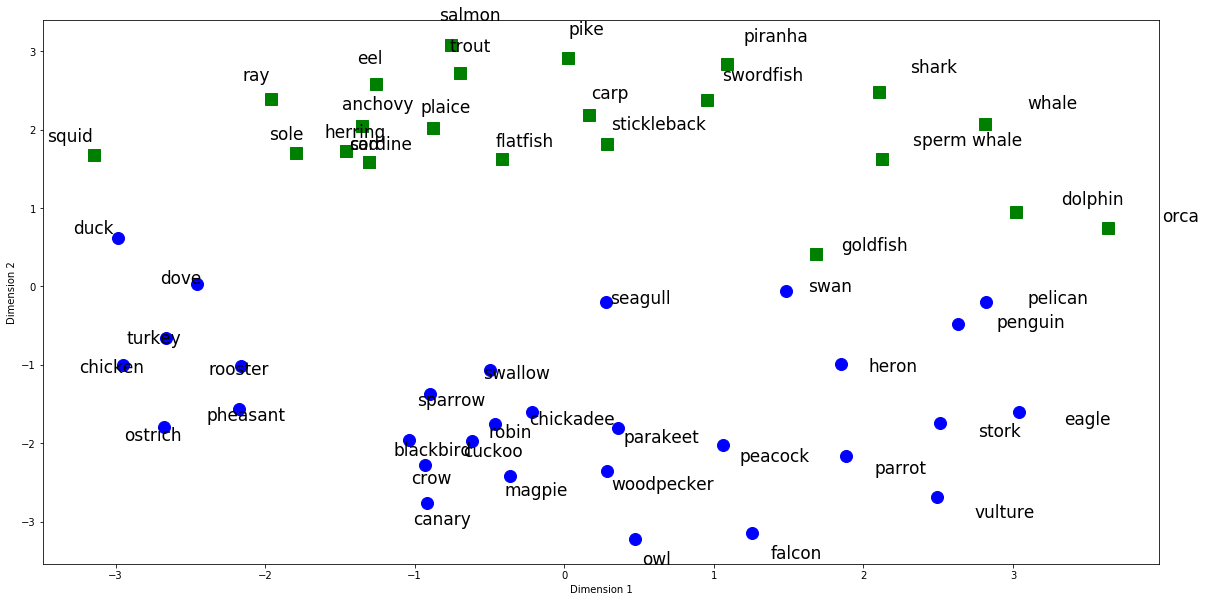

In [8]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2)
F_lowdim = embedding.fit_transform(F)

birdinds = np.where(labels==0)
fishinds = np.where(labels==1)

fig = plt.figure(figsize=(20, 10))
plt.plot(F_lowdim[birdinds,0],F_lowdim[birdinds,1],'bo',markersize=12)
plt.plot(F_lowdim[fishinds,0],F_lowdim[fishinds,1],'gs',markersize=12)

for i in range(0,len(F)):
    plt.text(F_lowdim[i,0]*1.1,F_lowdim[i,1]*1.1,names[i],fontsize=17)
    
plt.xlabel('Dimension 1')    
plt.ylabel('Dimension 2')    

# plt.show()

### Tasks 1-3 [10 pts] 
**Task 1**: Evaluate each model by standard leave-one-animal-out cross validation. **[2 pts]**

**Task 2**: Implement two models of categorization: a prototype model **[2pts]** and an exemplar model **[2pts]**.

**Task 3**: Report predictive accuracy of each model in percentage (i.e. % correct predictions out of 53 animals). **[1 pt]**

**Task 4**: Perform an error analysis on the two models (i.e. report which exemplars each model failed on), then compare and discuss why the errors look the way they do. **[3 pts]**


**Hint:** Consider using the following wrapper code for performing the leave-one-out (LOO) cross validation.

You may also want to refer to description and example code here: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html

In [9]:
###### Helper functions ######

### Lecture 6 slides ###

# Prototype Model - Use d(x,y) is Euclidean distance between x and y 

# Exemplar Model - Use # sim(x,y) = exp(-d(x,y)^2)

from functools import reduce
  
def avg(lst): 
    return reduce(lambda a, b: a + b, lst) / len(lst) 


def prototypeModel(train, test, labels):
    
    brd_lst = [spatial.distance.euclidean(train[i], test) for i in range(len(train)) if (labels[i] == 0)]
    fsh_lst = [spatial.distance.euclidean(train[i], test) for i in range(len(train)) if (labels[i] != 0)]
    prediction = 0 if avg(brd_lst) < avg(fsh_lst) else 1
    
    return prediction

def exemplarModel(train, test, labels):
    
    brd_lst = [np.exp((-spatial.distance.euclidean(train[i], test))**2) for i in range(len(train)) if (labels[i] == 0)]
    fsh_lst = [np.exp((-spatial.distance.euclidean(train[i], test))**2) for i in range(len(train)) if (labels[i] != 0)]
    prediction = 0 if avg(brd_lst) < avg(fsh_lst) else 1
    
    return prediction
    
def calculate(actual, predicted):
    actual_list = [i for i in range(len(actual)) if actual[i] == predicted[i]]
    return len(actual_list) / len(actual)

def get_incorrect_predictions(actual, predicted):
    actual_list = [i for i in range(len(actual)) if actual[i] != predicted[i]]
    return actual_list

###### Helper functions ######

In [10]:
loo = LeaveOneOut()
loo.get_n_splits(F)

proto = []
exemp = []
actual = []
for train_index, test_index in loo.split(F):

#
#     ...... your code here ......
#
#     1) Get training and testing data points
    F_train, F_test = F[train_index], F[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]
    actual.append(test_labels)

#     for train_index, test_index in loo.split(X):
# ...     print("TRAIN:", train_index, "TEST:", test_index)
# ...     X_train, X_test = X[train_index], X[test_index]
# ...     y_train, y_test = y[train_index], y[test_index]
# ...     print(X_train, X_test, y_train, y_test)

#     2.1) Implement and predict with prototype model
    a = prototypeModel(F_train, F_test, train_labels)
    proto.append(a)


    # 2.2) Implement and predict with exemplar model
    b = exemplarModel(F_train, F_test, train_labels)
    exemp.append(b)

    
#  3) Report predictive accuracies
print("Prototype Predicitive Accuracy: {}".format(calculate(actual, proto)))
print("Exemplar Predicitive Accuracy: {}".format(calculate(actual, exemp)))
print('---------------------------------------------------------------')

# 4) Error Analysis: Print out the names that Proto and Exemp did not catch.

incorrect_proto = get_incorrect_predictions(actual, proto)
incorrect_names_proto = [names[i] for i in incorrect_proto]
print('Incorrectly predicted names for Prototype Model:')
print(incorrect_names_proto)


incorrect_exemp = get_incorrect_predictions(actual, exemp)
incorrect_names_exemp = [names[i] for i in incorrect_exemp]
print('Incorrectly predicted names for Exemplar Model:')
print(incorrect_names_exemp)


Prototype Predicitive Accuracy: 0.9622641509433962
Exemplar Predicitive Accuracy: 0.9245283018867925
---------------------------------------------------------------
Incorrectly predicted names for Prototype Model:
['duck', 'goldfish']
Incorrectly predicted names for Exemplar Model:
['duck', 'penguin', 'goldfish', 'squid']


We see from the above result that the prototype model was overall more accurate both in terms of the predictive accuracy but also in terms of the actual predictions. By getting the incorrect labels that were predicted, I was able to use that index to print out the actual animal names that were predicted incorrectly for both models. The above shows that the prototype model predicted two elements incorrectly whereas the exemplar model had predicted four elements incorrectly. From the above, my analysis shows that the prototype model was more accurate for this case.

Export and submit a **fully executable** Python Jupyter Notebook and a PDF copy of your notebook showing all results. 